In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Lambda
from itertools import combinations
# for types hints
from typing import Tuple, Callable, List, Optional
from tensorflow import Tensor

Synthetic Data

In [2]:
# 4 input values, each Gaussian distributed with 0 mean and 1 stdev
# 1 output value, distance from the origin, AKA L2-norm
# 1000 instances for training, 1000 for testing

In [3]:
def create_synthetic_data(n_train=1000, n_test=1000, n_features=4):
    """
    Create a synthetic regression dataset.

    :param n_train: Number of training instances.
    :param n_test: Number of testing instances.
    :param n_features: Number of input features.
    :return: X_train, y_train, X_test, y_test
    """

    # Create training data
    X_train = np.random.normal(loc=0, scale=1, size=(n_train, n_features))
    # printing the 5 first elements in X_train
    print(X_train[:5])
    y_train = np.linalg.norm(X_train, axis=1)  # Compute the L2-norm
    # printing the 5 first elements in y_train
    print(y_train[:5])

    # Create testing data
    X_test = np.random.normal(loc=0, scale=1, size=(n_test, n_features))
    y_test = np.linalg.norm(X_test, axis=1)  # Compute the L2-norm


    return X_train, y_train, X_test, y_test

In [4]:
def normalize_labels(y: np.ndarray) -> np.ndarray:
    """
    Normalize the target values so they are between 0 and 2 using the equation:
    y' = 2 * (y - min) / (max - min) + min

    :param y: The original target values.
    :return: The normalized target values.
    """
    min_val = np.min(y)
    max_val = np.max(y)
    
    return 2 * (y - min_val) / (max_val - min_val) + min_val

In [5]:
# Generate the synthetic data
X_train, y_train, X_test, y_test = create_synthetic_data()
# print 5 first elements in X_train
print(X_train[:5])
# print 5 first elements in y_train
print(y_train[:5])
# print 5 first elements in X_test
print(X_test[:5])
# print 5 first elements in y_test
print(y_test[:5])
# Normalize the labels
y_train = normalize_labels(y_train)
# print 5 first elements in y_train
print(y_train[:5])
y_test = normalize_labels(y_test)
# print 5 first elements in y_test
print(y_test[:5])

# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

[[-0.25046294 -0.30301248 -0.10520591 -0.5401942 ]
 [ 0.4239371  -0.64463295  0.06603879  0.26950828]
 [-2.00572206  0.01570035 -0.82825094 -0.92728383]
 [ 1.58893139 -1.95579315  0.14561635  0.92429879]
 [ 2.24307926  0.06048863  0.09156801  2.57539868]]
[0.67633299 0.81992081 2.35987762 2.68800338 3.41703475]
[[-0.25046294 -0.30301248 -0.10520591 -0.5401942 ]
 [ 0.4239371  -0.64463295  0.06603879  0.26950828]
 [-2.00572206  0.01570035 -0.82825094 -0.92728383]
 [ 1.58893139 -1.95579315  0.14561635  0.92429879]
 [ 2.24307926  0.06048863  0.09156801  2.57539868]]
[0.67633299 0.81992081 2.35987762 2.68800338 3.41703475]
[[ 0.935026   -0.11774554 -1.35742261  0.8141987 ]
 [-0.28760472 -0.24189689  0.03473214 -0.2891338 ]
 [-0.48951008  0.68715766 -1.07558236  0.38631324]
 [-0.09287342  0.2582293   0.37345634  1.17322709]
 [-1.0507034  -1.82810328  0.29878191 -0.27293474]]
[1.8421871  0.47543165 1.42053549 1.26144333 2.14702195]
[0.47877197 0.55033936 1.31788832 1.48143354 1.8447991 ]
[1.0

Model Building

In [6]:
# NN for representation learning:
# 4 input nodes
# 1 or more hidden layers
# the last hidden layer has 2 nodes (representation layer Z)
# plot the instances in the 2D feature/representation space of Z 
# use different colors for different target values (can be in groups, each group with a different color) similar to the RankSim pictures
# training and test sets in different plots.
# expecting the instances to be in a semi-circle
# for prediction, add output layer of 1 node.


In [7]:
def create_model(hiddens: List[int]) -> tf.keras.Model:
    """
    Create a neural network model with two branches using the Keras functional API.
    One branch will be used for fitting the output to the label, and the other will use the Z features for the custom loss.
    The Z features are normalized to fit on the unit circle.

    :param hiddens: List of integers representing the number of nodes in each hidden layer.
    :return: The uncompiled model.
    """
    inputs = tf.keras.Input(shape=(4,))
    x = inputs
    # Define hidden layers according to architecture
    for nodes in hiddens:
        x = tf.keras.layers.Dense(nodes, activation='relu')(x)
    # Define the representation layer (Z features)
    repr_layer = tf.keras.layers.Dense(2, activation='relu', name='repr_layer')(x)
    # Normalize the representation layer to fit on the unit circle
    # repr_layer = Lambda(lambda z: z / tf.norm(z, axis=1, keepdims=True))(x)
    # Define the output layer for fitting to the label
    pred_output = tf.keras.layers.Dense(1, name='pred_output')(repr_layer)
    # Bundle the Z features and fitting output into a model
    model = tf.keras.Model(inputs=inputs, outputs=[pred_output]) #, repr_layer])

    return model



In [8]:
def get_groups(y: List[float]) -> Tuple[List[int], int, int]:
    """
    Find the minimum and maximum values in the dataset and create a list of integer groups between those values.

    :param y: The target values in the dataset.
    :return: A list of integer groups between the minimum and maximum values
    :return: The minimum value in the dataset.
    :return: The maximum value in the dataset.
    """
    min_val = int(min(y))
    max_val = int(max(y))
    
    return list(range(min_val, max_val + 1)), min_val, max_val


In [9]:
def plot_feature_space(model: tf.keras.Model, data: np.ndarray, labels: np.ndarray, groups: Optional[List[int]] = None):
    """
    Plot the instances in the 2D feature space of the representation layer (Z).

    :param model: Trained neural network model.
    :param data: Input data, shape of [num_instances, num_features].
    :param labels: Corresponding labels for the data.
    :param groups: Optional grouping for labels to define color assignment.
    """
    # Extract the representation layer from the model
    repr_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('repr_layer').output)

    # Predict the representation for the input data
    repr_space = repr_layer_model.predict(data)

    # If groups are defined, categorize labels into groups
    if groups:
        group_labels = [np.digitize(label, groups) for label in labels]
    else:
        group_labels = labels

    # Create a scatter plot for the representation space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(repr_space[:, 0], repr_space[:, 1], c=group_labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('2D Feature Space of Representation Layer')
    plt.show()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_6 (Dense)             (None, 16)                80        
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 repr_layer (Dense)          (None, 2)                 34        
                                                                 
 pred_output (Dense)         (None, 1)                 3         
                                                                 
Total params: 389
Trainable params: 389
Non-trainable params: 0
_________________________________________________________________


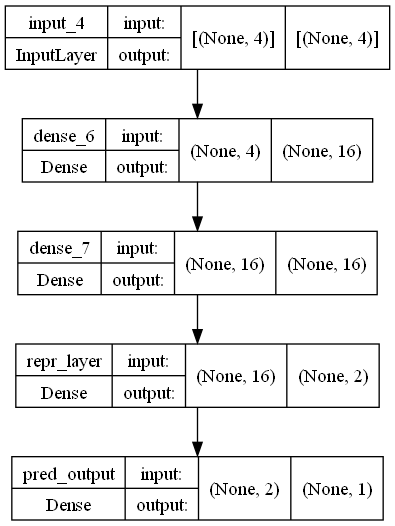

In [17]:
# Create and train the model
model = create_model([16, 16])
# summarize and plot the model
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Epoch 1/10
32/32 [==============================] - 0s 5ms/step - loss: 0.8482
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.4376
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.1824
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0794
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0333
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0181
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 10/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0088
Groups: [0, 1, 2, 3], Min: 0, Max: 3


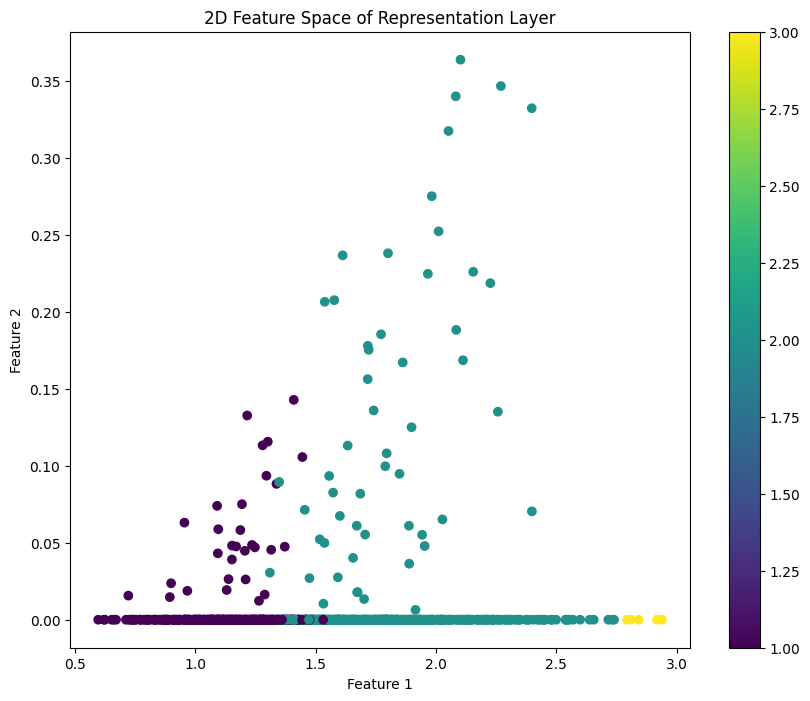

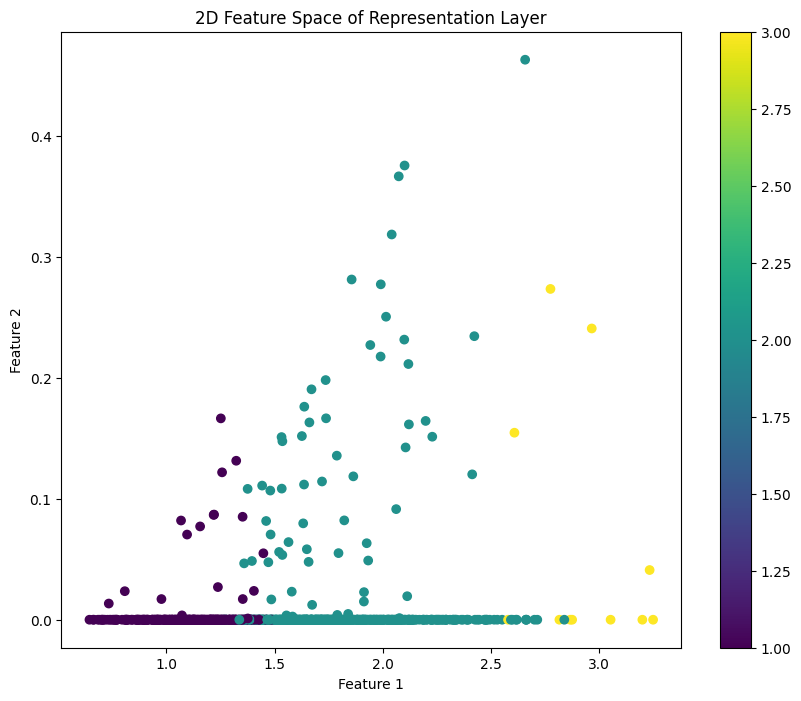

In [18]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32)
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model, X_train, y_train, groups)
plot_feature_space(model, X_test, y_test, groups)

Test of First Idea improving on ranksim

In [25]:
def zdist(vec1: tf.Tensor, vec2: tf.Tensor) -> float:
    """
    Computes the squared L2 norm distance between two input feature vectors.

    :param vec1: The first input feature vector.
    :param vec2: The second input feature vector.
    :return: The squared L2 norm distance.
    """
    return tf.reduce_sum(tf.square(vec1 - vec2))


def ydist(val1: float, val2: float) -> float:
    """
    Computes the squared distance between two label values.

    :param val1: The first label value.
    :param val2: The second label value.
    :return: The squared distance.
    """
    return (val1 - val2) ** 2

def error(z1: tf.Tensor, z2: tf.Tensor, label1: float, label2: float) -> float:
    """
    Computes the error between the zdist of two input predicted z values and their ydist.

    :param z1: The predicted z value for the first input sample.
    :param z2: The predicted z value for the second input sample.
    :param label1: The label of the first input sample.
    :param label2: The label of the second input sample.
    :return: The squared difference between the zdist and ydist.
    """
    squared_difference = (zdist(z1, z2) - ydist(label1, label2)) ** 2
    return tf.reduce_sum(squared_difference)


def custom_loss(labels, Zs):
    """
    Computes the loss for a batch of Zs and their corresponding labels.

    :param Zs: A batch of predicted Z values, shape of [batch_size, 2].
    :param labels: A batch of labels corresponding to the Zs, shape of [batch_size].
    :return: The average error for all unique combinations of the samples in the batch.
    """
    int_batch_size = tf.shape(Zs)[0]
    batch_size = tf.cast(int_batch_size, dtype=tf.float32)
    total_error = tf.constant(0.0, dtype=tf.float32)

    # Loop through all unique pairs of samples in the batch
    for i in tf.range(int_batch_size):
        for j in tf.range(i + 1, int_batch_size):
            z1, z2 = Zs[i], Zs[j]
            label1, label2 = labels[i], labels[j]
            err = error(z1, z2, label1, label2)
            total_error += tf.cast(err, dtype=tf.float32)

    # Calculate the average error
    average_error = total_error / (batch_size * (batch_size - 1) / 2)
    return average_error



In [32]:
class NormalizeLayer(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-7, **kwargs):
        self.epsilon = epsilon
        super(NormalizeLayer, self).__init__(**kwargs)

    def call(self, inputs):
        norm = tf.norm(inputs, axis=1, keepdims=True) + self.epsilon
        return inputs / norm

In [33]:
def create_model_feat(hiddens: List[int]) -> tf.keras.Model:
    """
    Create a neural network model with two branches using the Keras functional API.
    One branch will be used for fitting the output to the label, and the other will use the Z features for the custom loss.
    The Z features are normalized to fit on the unit circle.

    :param hiddens: List of integers representing the number of nodes in each hidden layer.
    :return: The uncompiled model.
    """
    inputs = tf.keras.Input(shape=(4,))
    x = inputs
    # Define hidden layers according to architecture
    for nodes in hiddens:
        x = tf.keras.layers.Dense(nodes, activation='relu')(x)
     # Define the representation layer (Z features)
    x = tf.keras.layers.Dense(2, activation='relu', name='repr_layer')(x)
    # Normalize the representation layer to fit on the unit circle
    repr_layer = NormalizeLayer()(x)
    # Define the output layer for fitting to the label
    pred_output = tf.keras.layers.Dense(1, name='pred_output')(repr_layer)
    # Bundle the Z features and fitting output into a model
    model = tf.keras.Model(inputs=inputs, outputs=[pred_output, repr_layer])

    return model


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_16 (Dense)            (None, 16)                80        
                                                                 
 dense_17 (Dense)            (None, 16)                272       
                                                                 
 repr_layer (Dense)          (None, 2)                 34        
                                                                 
 normalize_layer (NormalizeL  (None, 2)                0         
 ayer)                                                           
                                                                 
 pred_output (Dense)         (None, 1)                 3         
                                                          

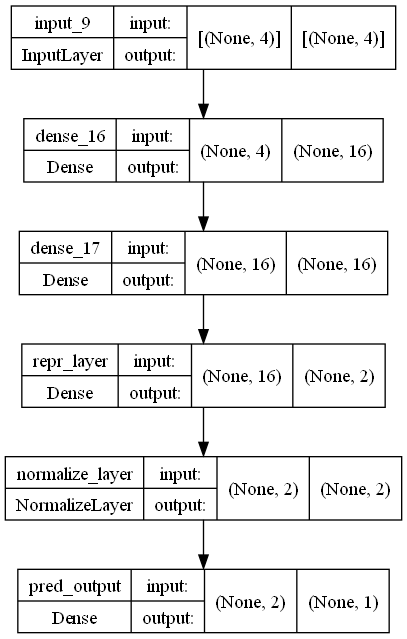

In [34]:
# Create and train the model
model_feat = create_model_feat([16, 16])
# summarize and plot the model
model_feat.summary()
tf.keras.utils.plot_model(model_feat, show_shapes=True)

In [36]:
model_feat.compile(optimizer='adam', loss=['mse', custom_loss])
model_feat.fit(X_train, [y_train, y_train], epochs=10, batch_size=1)
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat, X_train, y_train, groups)
plot_feature_space(model_feat, X_test, y_test, groups)


Epoch 1/10
 880/1000 [=========================>....] - ETA: 0s - loss: nan - pred_output_loss: 0.1148 - normalize_layer_loss: nan

KeyboardInterrupt: 